# Homework #2

## Setup

In [1]:
import numpy as np
import skimage as sk
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import fft, fftpack, stats

## Problems

### Problem 1

In [2]:
im = sk.io.imread('white-blood-cell.png')
im = sk.color.rgba2rgb(im)
im = sk.color.rgb2gray(im)
im = sk.util.img_as_float(im)

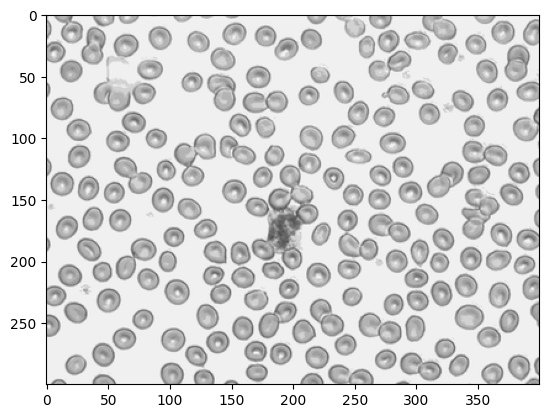

In [3]:
plt.imshow(im, cmap='gray', vmin=0, vmax=1)

**Part 1**

We will use a **spherical structure element** (disk footprint) for all operations.

In [4]:
footprint = sk.morphology.disk(6)

In [5]:
operations = {
    'Erosion': sk.morphology.erosion,
    'Dilation': sk.morphology.dilation,
    'Opening': sk.morphology.opening,
    'Closing': sk.morphology.closing,
    'White Tophat': sk.morphology.white_tophat,
    'Black Tophat': sk.morphology.black_tophat,
}

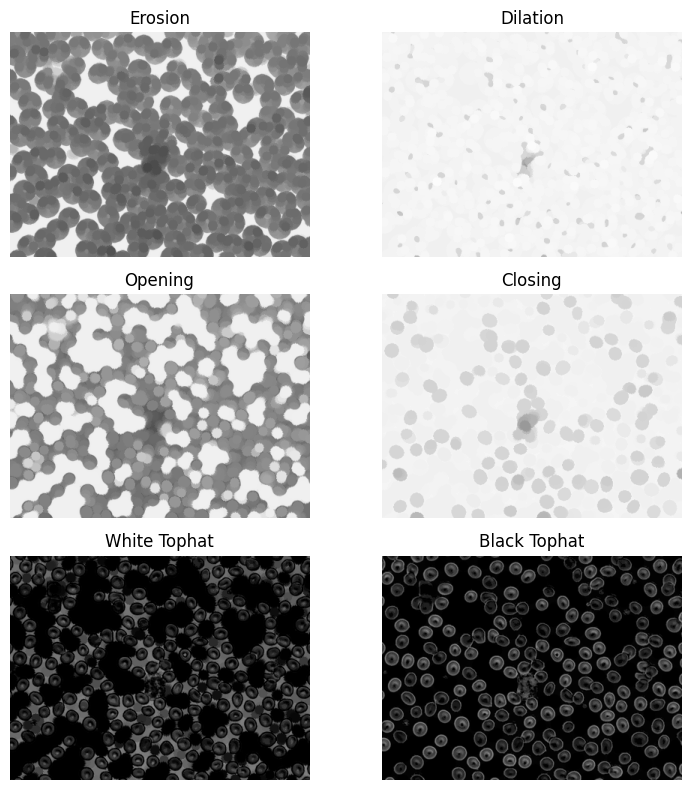

In [6]:
figure, axes = plt.subplots(len(operations) // 2, 2, figsize=(8, 8))
axes = [axis for row in axes for axis in row]
for axis, (name, operation) in zip(axes, operations.items()):
    result = operation(im, footprint)
    axis.imshow(result, cmap='gray', vmin=0, vmax=1)
    axis.set_title(name)
    axis.axis('off')
plt.tight_layout()

We can observe that:

- With **erosion** white boundaries within the image disappear, especially if we increase the size of the disk. 
- **Dilation** is the inverse of erosion. It enlarges bright regions and shrinks dark regions.
- **Opening** removes small bright spots and connect small dark cracks. In fact, since opening an image starts with an erosion operation, light regions that are smaller than the structuring element are removed. The dilation operation that follows ensures that light regions that are larger than the structuring element retain their original size.
- **Closing** removes small dark spots and connect small bright cracks. Dark regions that are smaller than the structuring element are removed and the dilation operation that follows ensures that dark regions that are larger than the structuring element retain their original size.
- The **white tophat** of an image is defined as the image minus its morphological opening. This operation returns the bright spots of the image that are smaller than the structuring element.
- The **black tophat** of an image is defined as its morphological closing minus the original image. This operation returns the dark spots of the image that are smaller than the structuring element.

**Part 2**

We can begin by applying a smoothing filter to image to remove some of the noise:

In [7]:
im_ = sk.filters.gaussian(im, sigma=1)

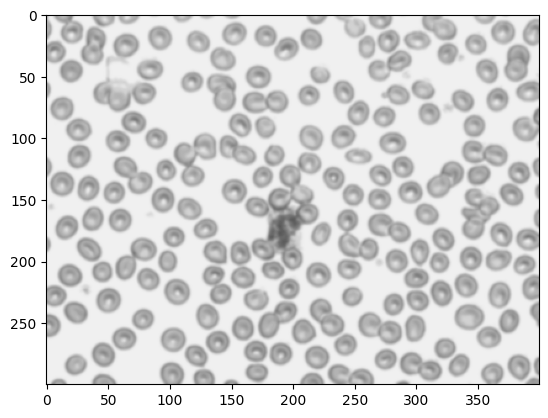

In [8]:
plt.imshow(im_, cmap='gray', vmin=0, vmax=1)

We then need to convert the image into a black and white pixel map by defining a threshold. A safe and straightforward option is the average pixel value:

In [9]:
threshold = sk.filters.threshold_mean(im_)
threshold

0.8144822371963384

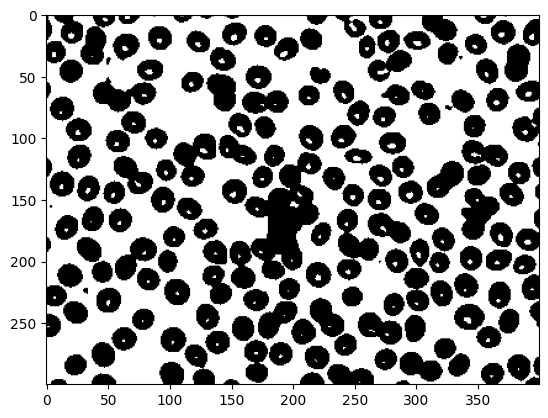

In [10]:
binary = im_ > threshold
plt.imshow(binary, cmap='gray')

In [11]:
morphed = binary

Next, since we want to count the dark regions in the image, the **black tophat** operation can be helpful.

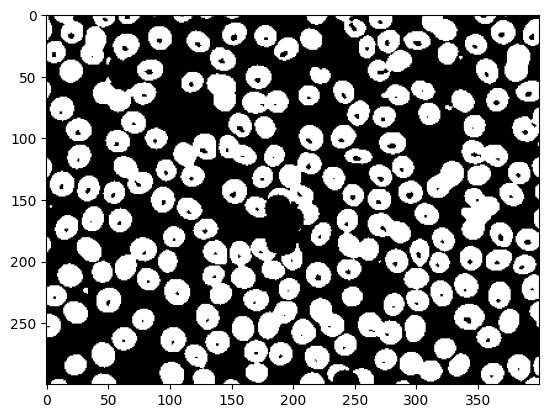

In [12]:
morphed = sk.morphology.black_tophat(morphed, sk.morphology.disk(10))
plt.imshow(morphed, cmap='gray')

We can then get rid of the black spots inside the cells using a modal filter:

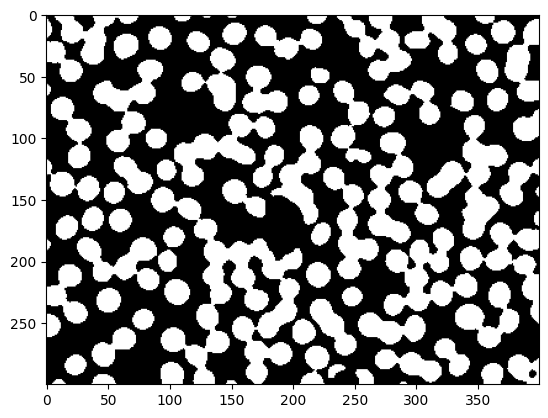

In [13]:
morphed = sk.filters.rank.modal(sk.util.img_as_ubyte(morphed), sk.morphology.disk(4))
plt.imshow(morphed, cmap='gray')

Finally, we can break apart (some of) the connected cells by expanding the darker regions.

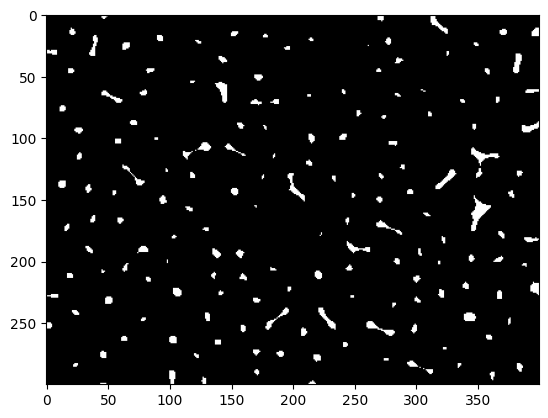

In [14]:
morphed = sk.morphology.erosion(morphed, sk.morphology.disk(7))
plt.imshow(morphed, cmap='gray')

Each bright region on the screen must now correspond to a cell. We can find these *blobs* using:

In [15]:
blobs = sk.feature.blob_dog(morphed, max_sigma=30, threshold=0.01)

In [16]:
print('Detected Blobs:', len(blobs))

Detected Blobs: 224


(-0.5, 399.5, 299.5, -0.5)

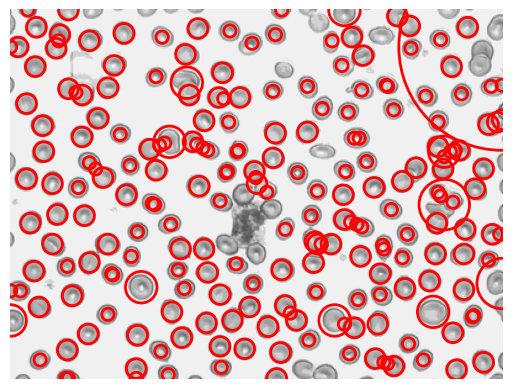

In [17]:
figure, axis = plt.subplots()
# axis.imshow(morphed, cmap='gray')
axis.imshow(im, cmap='gray', vmin=0, vmax=1)
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r * 5, linewidth=2, fill=False, color='red')
    axis.add_patch(c)
plt.axis('off')

A few cells have been missed, and a few overlapping regions have been mistakenly marked.

### Problem 2

In [18]:
im = sk.io.imread('MRI2.jpeg')
im = sk.color.rgb2gray(im)
im = sk.util.img_as_float(im)

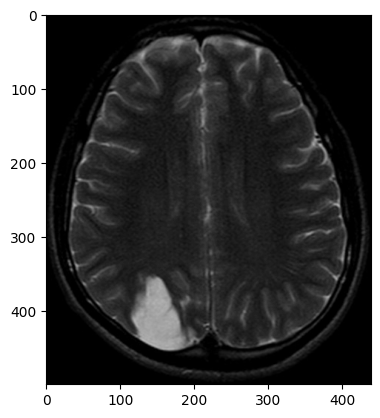

In [19]:
plt.imshow(im, cmap='gray', vmin=0, vmax=1)

**Otsu**

We will use the multi-otsu algorith, hoping to break the image into three segments: background, brain tissue, and the tumor.

In [20]:
thresholds = sk.filters.threshold_multiotsu(im, classes=3)

In [21]:
regions = np.digitize(im, bins=thresholds)

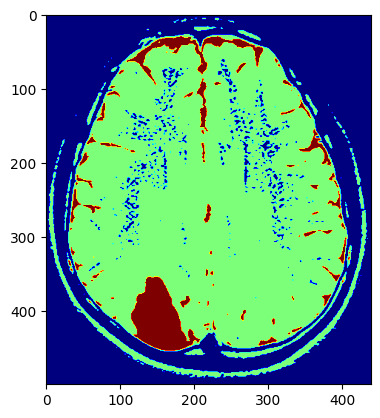

In [22]:
plt.imshow(regions, cmap='jet')

This approach incorrectly marks some of the brighter parts on outer regions as well. However, region growing won't include these parts, if we can pinpoint a good seed point. In our case, $(400, 150)$ seems to be a good seed.

In [23]:
segmented = sk.segmentation.flood_fill(regions, (400, 150), new_value=7)

In [24]:
print('Area:', np.sum(segmented == 7), 'pixels')

Area: 5112 pixels


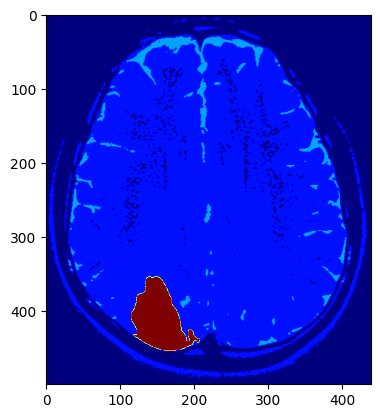

In [25]:
plt.imshow(segmented, cmap='jet')

**K-Means**

We will use the elbrow technique to find the best number of clusters.

In [26]:
num_clusters = np.arange(3, 20)

In [27]:
scores = [KMeans(num, random_state=1).fit(im.reshape(-1, 1)).inertia_ for num in tqdm(num_clusters)]

  0%|          | 0/17 [00:00<?, ?it/s]

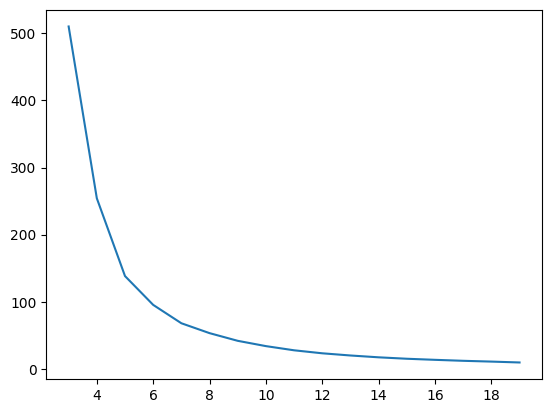

In [28]:
plt.plot(num_clusters, scores)

7 seems to be a good option.

In [29]:
regions = KMeans(n_clusters=7, random_state=1).fit_predict(im.reshape(-1, 1)).reshape(im.shape)

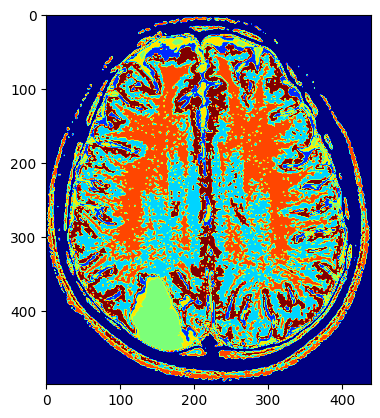

In [30]:
plt.imshow(regions, cmap='jet')

The cluster associated with the tumor still includes a few incorrect pixels. Yet, the growing region algorithm should result in a clean cut.

In [31]:
segmented = sk.segmentation.flood_fill(regions, (400, 150), new_value=50)

In [32]:
print('Area:', np.sum(segmented == 50), 'pixels')

Area: 4135 pixels


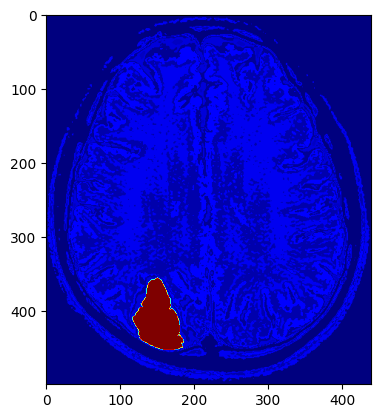

In [33]:
plt.imshow(segmented, cmap='jet')

K-Means seems to be more precise, compared to Otsu. We might achieved a better result with Otsu, had we used a larger number of bins. However, Otus isn't as fast as K-Means.

### Problem 3

In [34]:
im = sk.io.imread('Normal-fundus-LRG-Without-Logo.jpg')
im = sk.util.img_as_float(im)

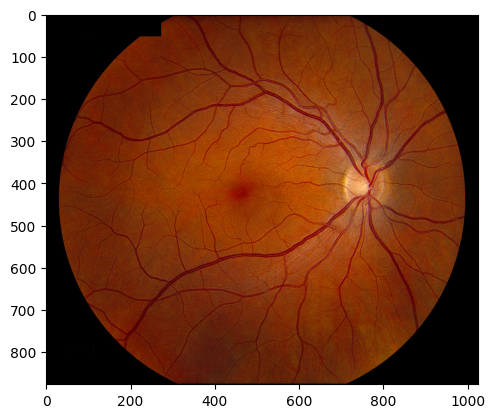

In [35]:
plt.imshow(im, vmin=0, vmax=1)

*I have removed the top left logo, so that it wouldn't mess with our calculations.*

Following [related studies](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0158996), we will only focus on the greenband of the image.

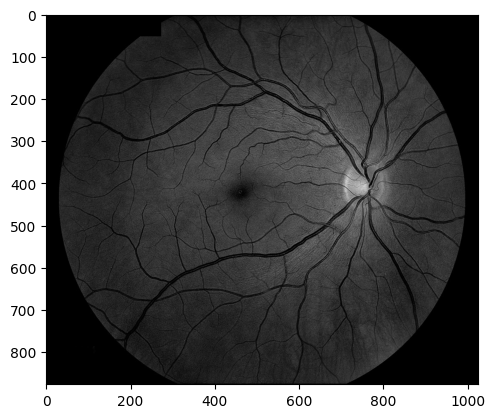

In [36]:
im = im[:, :, 1]
plt.imshow(im, cmap='gray', vmin=0, vmax=1)

We can begin by first improving the contrast of the image. We will use the **CLAHE** algorithm.

In [37]:
im = sk.exposure.equalize_adapthist(im, kernel_size=15)

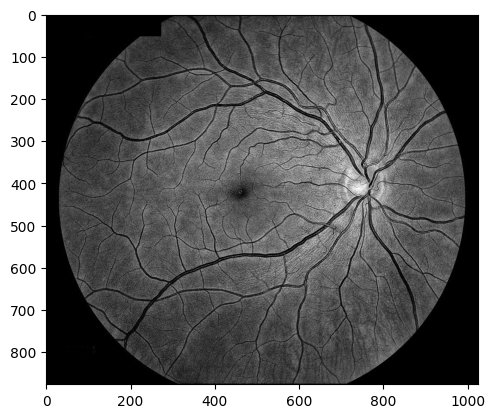

In [38]:
plt.imshow(im, cmap='gray', vmin=0, vmax=1)

Next, we can perform a few morphological operations to enhance the visibility of the vessels. For these operations, considering the relative size of the vessels, we can use a disk-shaped structural element with a small size.

In [39]:
footprint = sk.morphology.disk(5)

In order to ger rid of some of the noise, we can perform a closing operation (to eliminate small dark spots) followed by an opening operation (to enhance remaining dark spots). We will subtract the result from the image, leaving us with the prominant dark spots of the image.

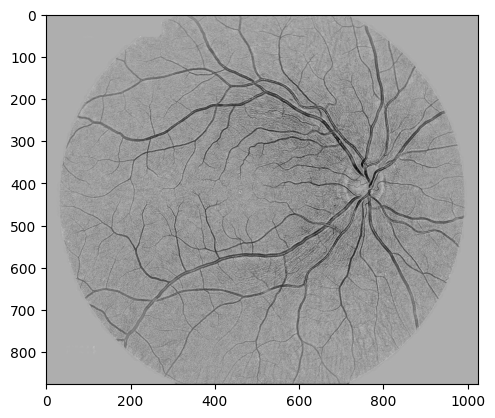

In [40]:
x = sk.morphology.opening(sk.morphology.closing(im, footprint), footprint)
plt.imshow(im - x, cmap='gray')
deducted = im - x

Finally, we can use thresholding the extract the darker regions, which are the vessels. Since we only need a few segments, we can use Otsu.

In [41]:
thresholds = sk.filters.threshold_multiotsu(deducted, classes=3)

In [42]:
regions = np.digitize(deducted, bins=thresholds)

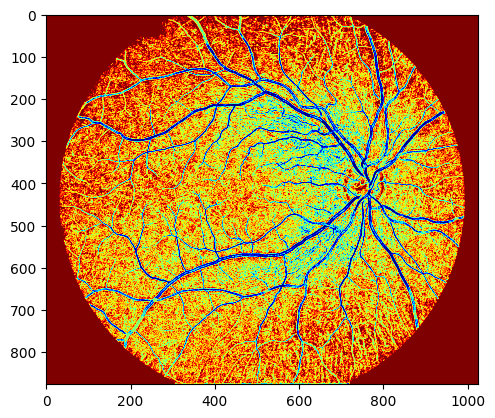

In [43]:
plt.imshow(regions, cmap='jet')

We need the segment that corresponds to the darkest regions. That should be associated with the lowest threshold.

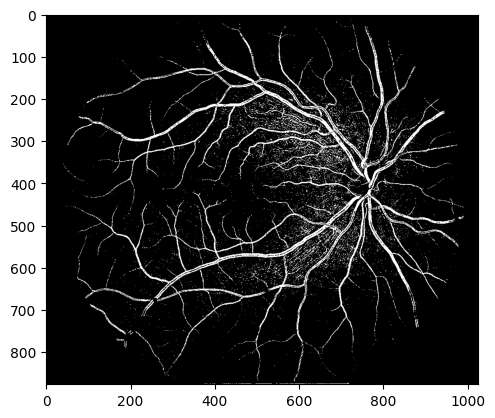

In [44]:
plt.imshow(regions == 0, cmap='gray')

It is clear that by tweaking the number of bins in Otsu, we can control the sensitivity towards smaller vessels (and noise).

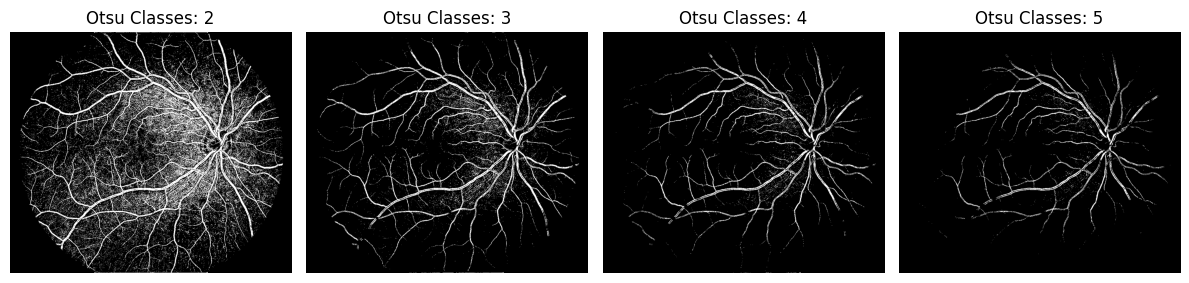

In [45]:
num_classes = np.arange(2, 6)
figure, axes = plt.subplots(1, 4, figsize=(12, 12))
for classes, axis in zip(num_classes, axes):
    thresholds = sk.filters.threshold_multiotsu(deducted, classes=classes)
    regions = np.digitize(deducted, bins=thresholds)
    axis.set_title(f'Otsu Classes: {classes}')
    axis.imshow(regions == 0, cmap='gray')
    axis.axis('off')
plt.tight_layout()